# DAX Intraday Volatility Regime Analysis
## Using Early-Session Volatility to Predict Full-Day Volatility Regimes

**Objective:** Determine if first-hour volatility (09:00-10:00 Berlin time) on DAX effectively predicts the full trading day's volatility regime.

**Data:** M5 (5-minute) OHLCV bars, Jan 2023 – Sept 2025, UTC storage with Berlin timezone conversion.

**Key Question:** If the opening hour is volatile, is the entire day likely to be volatile? Can we use this signal for position sizing?

---

## Part 1: Data Engineering & DST Handling

### Critical Requirements:
1. **Timezone Normalization:** UTC → Europe/Berlin (CET/CEST with DST)
2. **RTH Filtering:** Keep only 09:00-17:30 Berlin time
3. **True Range Calculation:** Using m5 granularity
4. **DST Awareness:** Verify offset changes at DST transitions


In [1]:
import sys
sys.path.insert(0, '../../')

from shared.database_connector import fetch_ohlcv, get_date_range
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print('[OK] Dependencies loaded')
print('='*80)

[OK] Dependencies loaded


## Step 1: Fetch M5 Data and Timezone Conversion


In [2]:
print('\n[STEP 1] Fetching M5 Data and Timezone Conversion')
print('='*80)

# Get available date range
date_range = get_date_range('deuidxeur', 'm5')
end_date = date_range['end']
start_date = end_date - timedelta(days=730)  # ~2 years for sufficient regime history

print(f'Available date range: {date_range["start"].date()} to {date_range["end"].date()}')
print(f'Requesting: {start_date.date()} to {end_date.date()}')

# Fetch M5 data
df_raw = fetch_ohlcv(
    symbol='deuidxeur',
    timeframe='m5',
    start_date=start_date,
    end_date=end_date
)

print(f'[OK] Fetched {len(df_raw)} M5 candles')
print(f'Raw index (UTC): {df_raw.index[0]} to {df_raw.index[-1]}')

# ============================================================================
# CRITICAL: Timezone Conversion to Berlin Time
# ============================================================================

# The database stores UTC. Convert to Berlin time (CET/CEST with DST)
df = df_raw.copy()
df.index = df.index.tz_convert('Europe/Berlin')

print(f'\nConverted to Berlin time: {df.index[0]} to {df.index[-1]}')

# Extract time components for filtering
df['date'] = df.index.date
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df['time_minutes'] = df['hour'] * 60 + df['minute']
df['tz_offset'] = df.index.strftime('%z')

# Show timezone info at key DST transition dates
print('\n[DST Verification] Checking timezone offsets:')
sample_dates = pd.to_datetime(['2025-01-15', '2025-03-30', '2025-06-15', '2025-10-25']).tz_localize('UTC')
for sample_date in sample_dates:
    sample_tz = df[(df.index >= sample_date) & (df.index < sample_date + timedelta(hours=1))]
    if len(sample_tz) > 0:
        offset = sample_tz.iloc[0]['tz_offset']
        regime = 'CET (UTC+1) Winter' if offset == '+0100' else 'CEST (UTC+2) Summer' if offset == '+0200' else f'Unknown ({offset})'
        print(f'  {sample_date.date()}: {regime}')

2025-11-25 22:12:23,365 - shared.database_connector - INFO - Initializing database connection...
2025-11-25 22:12:23,366 - shared.database_connector - WARNING - CA certificate not found at certs\ca-certificate.crt. Connecting without SSL verification.



[STEP 1] Fetching M5 Data and Timezone Conversion


2025-11-25 22:12:24,078 - shared.database_connector - INFO - [OK] Database connection successful
2025-11-25 22:12:24,359 - shared.database_connector - INFO - [OK] Date range for deuidxeur m5: 2023-01-08 23:00:00+00:00 to 2025-09-16 21:55:00+00:00
2025-11-25 22:12:24,360 - shared.database_connector - INFO - fetch_ohlcv(): symbol=deuidxeur, timeframe=m5, start=2023-09-17 21:55:00+00:00, end=2025-09-16 21:55:00+00:00


Available date range: 2023-01-08 to 2025-09-16
Requesting: 2023-09-17 to 2025-09-16


2025-11-25 22:12:25,910 - shared.database_connector - INFO - [OK] Fetched 136661 candles (2023-09-17 21:55:00+00:00 to 2025-09-16 21:55:00+00:00)


[OK] Fetched 136661 M5 candles
Raw index (UTC): 2023-09-17 21:55:00+00:00 to 2025-09-16 21:55:00+00:00

Converted to Berlin time: 2023-09-17 23:55:00+02:00 to 2025-09-16 23:55:00+02:00

[DST Verification] Checking timezone offsets:
  2025-01-15: CET (UTC+1) Winter


## Step 2: RTH Filtering and True Range Calculation


In [3]:
print('\n[STEP 2] RTH Filtering and True Range Calculation')
print('='*80)

# ============================================================================
# Filter for Regular Trading Hours (RTH): 09:00-17:30 Berlin Time
# ============================================================================

# Keep only bars during RTH
df_rth = df[(df['hour'] >= 9) & ((df['hour'] < 17) | ((df['hour'] == 17) & (df['minute'] <= 30)))].copy()

print(f'[OK] Filtered to RTH (09:00-17:30 Berlin time)')
print(f'Remaining candles: {len(df_rth)} (from {len(df)})')
print(f'Date range: {df_rth.index[0]} to {df_rth.index[-1]}')

# ============================================================================
# True Range (TR) Calculation for M5 Bars
# ============================================================================

# Standard formula:
# TR = max(H - L, |H - C_prev|, |L - C_prev|)

# For the first bar of each day, use previous day's close
df_rth['c_prev'] = df_rth['close'].shift(1)

# When shifting crosses day boundary, mark as NaN to handle specially
day_boundary = df_rth['date'] != df_rth['date'].shift(1)
df_rth.loc[day_boundary, 'c_prev'] = np.nan

# Calculate True Range
df_rth['hl_range'] = df_rth['high'] - df_rth['low']
df_rth['h_cp_range'] = (df_rth['high'] - df_rth['c_prev']).abs()
df_rth['l_cp_range'] = (df_rth['low'] - df_rth['c_prev']).abs()

# For first bar of day (no previous close), use H-L only
df_rth['tr'] = df_rth[['hl_range', 'h_cp_range', 'l_cp_range']].max(axis=1)
df_rth.loc[day_boundary, 'tr'] = df_rth.loc[day_boundary, 'hl_range']

print(f'\n[OK] True Range calculated for all M5 bars')
print(f'\nSample TR calculation (first 10 RTH bars):')
sample_cols = ['date', 'hour', 'minute', 'high', 'low', 'close', 'c_prev', 'tr']
print(df_rth[sample_cols].head(10).to_string())

print(f'\nTR Statistics:')
print(f'  Mean: {df_rth["tr"].mean():.2f}')
print(f'  Std: {df_rth["tr"].std():.2f}')
print(f'  Min: {df_rth["tr"].min():.2f}')
print(f'  Max: {df_rth["tr"].max():.2f}')


[STEP 2] RTH Filtering and True Range Calculation
[OK] Filtered to RTH (09:00-17:30 Berlin time)
Remaining candles: 53005 (from 136661)
Date range: 2023-09-18 09:00:00+02:00 to 2025-09-16 17:30:00+02:00

[OK] True Range calculated for all M5 bars

Sample TR calculation (first 10 RTH bars):
                                 date  hour  minute       high        low      close     c_prev     tr
timestamp                                                                                             
2023-09-18 09:00:00+02:00  2023-09-18     9       0  15816.779  15803.779  15805.779        NaN  13.00
2023-09-18 09:05:00+02:00  2023-09-18     9       5  15820.799  15803.259  15819.759  15805.779  17.54
2023-09-18 09:10:00+02:00  2023-09-18     9      10  15819.399  15799.279  15804.759  15819.759  20.48
2023-09-18 09:15:00+02:00  2023-09-18     9      15  15810.399  15800.779  15803.759  15804.759   9.62
2023-09-18 09:20:00+02:00  2023-09-18     9      20  15806.789  15794.759  15800.259  1580

## Part 2: Feature Construction - Daily Volatility Regimes


In [4]:
print('\n[STEP 3] Daily Volatility Aggregation and Regime Labeling')
print('='*80)

# Group by date to calculate daily metrics
daily_metrics = []

for date, day_data in df_rth.groupby('date'):
    if len(day_data) < 12:  # Need at least 12 bars (1 hour) for a valid trading day
        continue
    
    # Daily metrics
    daily_open = day_data.iloc[0]['open']
    daily_close = day_data.iloc[-1]['close']
    daily_high = day_data['high'].max()
    daily_low = day_data['low'].min()
    
    # Sum of True Range for the full day (09:00-17:30)
    daily_tr_sum = day_data['tr'].sum()
    
    # ATR % (True Range as % of closing price)
    atrp = (daily_tr_sum / daily_close) * 100 if daily_close > 0 else 0
    
    row = {
        'date': date,
        'daily_open': daily_open,
        'daily_close': daily_close,
        'daily_high': daily_high,
        'daily_low': daily_low,
        'daily_range_pts': daily_high - daily_low,
        'daily_tr_sum': daily_tr_sum,
        'atrp': atrp,
        'n_bars': len(day_data),
    }
    
    # Early session (09:00-10:00 = first 12 bars of M5)
    early_bars = day_data.iloc[:12] if len(day_data) >= 12 else day_data
    early_tr_sum = early_bars['tr'].sum()
    early_trp = (early_tr_sum / daily_open) * 100 if daily_open > 0 else 0
    
    row['early_tr_sum'] = early_tr_sum
    row['early_trp'] = early_trp
    
    # Rest of day (10:00-17:30)
    if len(day_data) > 12:
        rest_bars = day_data.iloc[12:]
        rest_tr_sum = rest_bars['tr'].sum()
        rest_trp = (rest_tr_sum / daily_open) * 100 if daily_open > 0 else 0
    else:
        rest_tr_sum = 0
        rest_trp = 0
    
    row['rest_tr_sum'] = rest_tr_sum
    row['rest_trp'] = rest_trp
    
    daily_metrics.append(row)

df_daily = pd.DataFrame(daily_metrics).sort_values('date').reset_index(drop=True)

print(f'[OK] Calculated daily metrics for {len(df_daily)} trading days')
print(f'Date range: {df_daily["date"].min()} to {df_daily["date"].max()}')

print(f'\nDaily Metrics Summary:')
print(f'  ATRP (full day): mean={df_daily["atrp"].mean():.3f}, std={df_daily["atrp"].std():.3f}')
print(f'  Early TRP: mean={df_daily["early_trp"].mean():.3f}, std={df_daily["early_trp"].std():.3f}')
print(f'  Rest TRP: mean={df_daily["rest_trp"].mean():.3f}, std={df_daily["rest_trp"].std():.3f}')

print(f'\nSample daily data (first 10 days):')
sample_daily = df_daily[['date', 'daily_open', 'atrp', 'early_trp', 'rest_trp', 'n_bars']].head(10)
print(sample_daily.to_string(index=False))


[STEP 3] Daily Volatility Aggregation and Regime Labeling
[OK] Calculated daily metrics for 515 trading days
Date range: 2023-09-18 to 2025-09-16

Daily Metrics Summary:
  ATRP (full day): mean=8.750, std=4.704
  Early TRP: mean=1.064, std=0.485
  Rest TRP: mean=7.688, std=4.337

Sample daily data (first 10 days):
      date  daily_open      atrp  early_trp  rest_trp  n_bars
2023-09-18   15809.259  8.542635   1.007511  7.495645     103
2023-09-19   15714.779  7.342291   0.873445  6.447676     103
2023-09-20   15761.549  5.893294   0.856870  5.048920     103
2023-09-21   15658.399  8.580746   0.973599  7.558512     103
2023-09-22   15528.289  8.313157   0.988390  7.321502     103
2023-09-25   15415.759  9.823364   1.325682  8.491577     103
2023-09-26   15340.749 10.195543   1.302414  8.826609     103
2023-09-27   15266.769  9.902418   1.212961  8.610584     103
2023-09-28   15180.769 11.037884   1.482138  9.651672     103
2023-09-29   15417.397 10.284584   1.088770  9.154723     103


## Step 4: Volatility Regime Labeling (Rolling Percentile)


In [5]:
print('\n[STEP 4] Volatility Regime Labeling (Rolling Percentile Rank)')
print('='*80)

# ============================================================================
# Rolling Percentile Rank (60-day lookback window)
# ============================================================================

# For each day, calculate the percentile rank of ATRP in the prior 60 days
lookback_days = 60

df_daily['atrp_percentile_rank'] = df_daily['atrp'].rolling(window=lookback_days+1).apply(
    lambda x: stats.percentileofscore(x[:-1], x.iloc[-1]),
    raw=False
)

# Create regime labels based on percentile rank
def label_regime(percentile_rank):
    if pd.isna(percentile_rank):
        return 'Unknown'
    elif percentile_rank < 33.33:
        return 'Low'
    elif percentile_rank < 66.67:
        return 'Normal'
    else:
        return 'High'

df_daily['regime'] = df_daily['atrp_percentile_rank'].apply(label_regime)

print(f'[OK] Regimes assigned based on 60-day rolling percentile rank')

# Drop the first 60 days (insufficient history for percentile rank)
df_daily_valid = df_daily[df_daily['regime'] != 'Unknown'].reset_index(drop=True)

print(f'\nValid regimes (with 60-day history): {len(df_daily_valid)} days')
print(f'\nRegime Distribution:')
regime_dist = df_daily_valid['regime'].value_counts()
for regime, count in regime_dist.items():
    pct = count / len(df_daily_valid) * 100
    print(f'  {regime:8} {count:3d} days ({pct:5.1f}%)')

print(f'\nATRP by Regime:')
for regime in ['Low', 'Normal', 'High']:
    regime_data = df_daily_valid[df_daily_valid['regime'] == regime]['atrp']
    print(f'  {regime:8} mean={regime_data.mean():.3f}, std={regime_data.std():.3f}, min={regime_data.min():.3f}, max={regime_data.max():.3f}')

print(f'\nSample regime assignments:')
sample_regime = df_daily_valid[['date', 'atrp', 'atrp_percentile_rank', 'regime']].iloc[100:110]
print(sample_regime.to_string(index=False))


[STEP 4] Volatility Regime Labeling (Rolling Percentile Rank)
[OK] Regimes assigned based on 60-day rolling percentile rank

Valid regimes (with 60-day history): 455 days

Regime Distribution:
  Low      167 days ( 36.7%)
  High     147 days ( 32.3%)
  Normal   141 days ( 31.0%)

ATRP by Regime:
  Low      mean=6.351, std=1.174, min=3.596, max=10.011
  Normal   mean=7.947, std=1.504, min=5.552, max=13.590
  High     mean=12.346, std=7.198, min=7.030, max=64.212

Sample regime assignments:
      date     atrp  atrp_percentile_rank regime
2024-05-03 9.209759             86.666667   High
2024-05-06 5.484035             31.666667    Low
2024-05-07 6.104019             46.666667 Normal
2024-05-08 5.551850             33.333333 Normal
2024-05-09 5.906970             43.333333 Normal
2024-05-10 5.257975             20.000000    Low
2024-05-13 4.201958              1.666667    Low
2024-05-14 4.977460             13.333333    Low
2024-05-15 6.068680             45.000000 Normal
2024-05-16 5.50

## Step 5: Early Session Relative Strength


In [6]:
print('\n[STEP 5] Early Session Relative Strength (20-day EMA)')
print('='*80)

# ============================================================================
# Calculate Early Session Relative Strength
# ============================================================================

# Early_Ratio = Early_TRP / Average(Early_TRP over last 20 days)
# This tells us: "Is this morning spicier than recent mornings?"

lookback_early = 20

df_daily_valid['early_trp_mean_20'] = df_daily_valid['early_trp'].rolling(
    window=lookback_early,
    min_periods=1
).mean()

df_daily_valid['early_ratio'] = (
    df_daily_valid['early_trp'] / df_daily_valid['early_trp_mean_20']
)

print(f'[OK] Calculated Early Session Relative Strength')
print(f'\nEarly_Ratio Statistics:')
print(f'  Mean: {df_daily_valid["early_ratio"].mean():.3f}')
print(f'  Std: {df_daily_valid["early_ratio"].std():.3f}')
print(f'  Min: {df_daily_valid["early_ratio"].min():.3f}')
print(f'  Max: {df_daily_valid["early_ratio"].max():.3f}')
print(f'  25th %ile: {df_daily_valid["early_ratio"].quantile(0.25):.3f}')
print(f'  Median: {df_daily_valid["early_ratio"].median():.3f}')
print(f'  75th %ile: {df_daily_valid["early_ratio"].quantile(0.75):.3f}')

# Create bins for early session strength
df_daily_valid['early_strength_quartile'] = pd.qcut(
    df_daily_valid['early_ratio'],
    q=4,
    labels=['Q1_Quiet', 'Q2_Normal', 'Q3_Active', 'Q4_Spicy'],
    duplicates='drop'
)

print(f'\nEarly Strength Quartiles:')
for quartile in ['Q1_Quiet', 'Q2_Normal', 'Q3_Active', 'Q4_Spicy']:
    q_data = df_daily_valid[df_daily_valid['early_strength_quartile'] == quartile]
    if len(q_data) > 0:
        print(f'  {quartile:10} {len(q_data):3d} days, early_ratio: {q_data["early_ratio"].mean():.3f}±{q_data["early_ratio"].std():.3f}')


[STEP 5] Early Session Relative Strength (20-day EMA)
[OK] Calculated Early Session Relative Strength

Early_Ratio Statistics:
  Mean: 1.012
  Std: 0.320
  Min: 0.209
  Max: 2.648
  25th %ile: 0.813
  Median: 0.958
  75th %ile: 1.151

Early Strength Quartiles:
  Q1_Quiet   114 days, early_ratio: 0.688±0.115
  Q2_Normal  114 days, early_ratio: 0.880±0.045
  Q3_Active  113 days, early_ratio: 1.047±0.058
  Q4_Spicy   114 days, early_ratio: 1.433±0.298


## Part 3: Statistical Validation - Correlation Analysis


In [7]:
print('\n[STEP 6] Correlation Analysis (Linear Relationship)')
print('='*80)

# ============================================================================
# Test: Does Early Session Volatility Predict Full-Day Volatility?
# ============================================================================

# Remove NaN values
analysis_data = df_daily_valid[['early_trp', 'rest_trp', 'atrp']].dropna()

print(f'\nAnalysis sample: {len(analysis_data)} days')

# 1. Early vs Full-Day ATRP
pearson_r_early_daily, p_value_early_daily = stats.pearsonr(analysis_data['early_trp'], analysis_data['atrp'])
spearman_r_early_daily, spearman_p_early_daily = stats.spearmanr(analysis_data['early_trp'], analysis_data['atrp'])

print(f'\n[Correlation 1] Early Session Volatility vs Full-Day Volatility')
print(f'  Pearson r: {pearson_r_early_daily:.4f} (p-value: {p_value_early_daily:.4f})')
print(f'  Spearman ρ: {spearman_r_early_daily:.4f} (p-value: {spearman_p_early_daily:.4f})')
print(f'  R²: {pearson_r_early_daily**2:.4f} (explains {pearson_r_early_daily**2*100:.1f}% of variance)')
print(f'  Significance: {"YES (reject H0)" if p_value_early_daily < 0.05 else "NO (cannot reject H0)"}')

# 2. Early vs Rest-of-Day ATRP
pearson_r_early_rest, p_value_early_rest = stats.pearsonr(analysis_data['early_trp'], analysis_data['rest_trp'])
spearman_r_early_rest, spearman_p_early_rest = stats.spearmanr(analysis_data['early_trp'], analysis_data['rest_trp'])

print(f'\n[Correlation 2] Early Session Volatility vs Rest-of-Day Volatility')
print(f'  Pearson r: {pearson_r_early_rest:.4f} (p-value: {p_value_early_rest:.4f})')
print(f'  Spearman ρ: {spearman_r_early_rest:.4f} (p-value: {spearman_p_early_rest:.4f})')
print(f'  R²: {pearson_r_early_rest**2:.4f} (explains {pearson_r_early_rest**2*100:.1f}% of variance)')
print(f'  Significance: {"YES (reject H0)" if p_value_early_rest < 0.05 else "NO (cannot reject H0)"}')


[STEP 6] Correlation Analysis (Linear Relationship)

Analysis sample: 455 days

[Correlation 1] Early Session Volatility vs Full-Day Volatility
  Pearson r: 0.8695 (p-value: 0.0000)
  Spearman ρ: 0.7440 (p-value: 0.0000)
  R²: 0.7560 (explains 75.6% of variance)
  Significance: YES (reject H0)

[Correlation 2] Early Session Volatility vs Rest-of-Day Volatility
  Pearson r: 0.8398 (p-value: 0.0000)
  Spearman ρ: 0.6868 (p-value: 0.0000)
  R²: 0.7053 (explains 70.5% of variance)
  Significance: YES (reject H0)


## Step 7: Predictive Power - Classification Analysis


In [9]:
print('\n[STEP 7] Predictive Power - Classification Analysis')
print('='*80)

# ============================================================================
# Can Early Session Strength Predict Regime Classification?
# ============================================================================

# Split into training/calibration and out-of-sample
# Training: Earlier dates, Out-of-Sample: Later dates

# Convert to datetime if needed for calculation
df_daily_valid['date_dt'] = pd.to_datetime(df_daily_valid['date'])
mid_date = df_daily_valid['date_dt'].min() + (df_daily_valid['date_dt'].max() - df_daily_valid['date_dt'].min()) / 2

df_train = df_daily_valid[df_daily_valid['date_dt'] < mid_date].copy()
df_oos = df_daily_valid[df_daily_valid['date_dt'] >= mid_date].copy()

print(f'Training set: {df_train["date"].min()} to {df_train["date"].max()} ({len(df_train)} days)')
print(f'Out-of-Sample: {df_oos["date"].min()} to {df_oos["date"].max()} ({len(df_oos)} days)')

# ============================================================================
# Conditional Probability Analysis
# ============================================================================

print(f'\n[Regime Distribution - Training Set]')
for regime in ['Low', 'Normal', 'High']:
    regime_count = (df_train['regime'] == regime).sum()
    regime_pct = regime_count / len(df_train) * 100
    print(f'  {regime:8} {regime_count:3d} days ({regime_pct:5.1f}%)')

print(f'\n[Regime Distribution - Out-of-Sample]')
for regime in ['Low', 'Normal', 'High']:
    regime_count = (df_oos['regime'] == regime).sum()
    regime_pct = regime_count / len(df_oos) * 100
    print(f'  {regime:8} {regime_count:3d} days ({regime_pct:5.1f}%)')

# ============================================================================
# Conditional Probability: P(Regime | Early Strength Quartile)
# ============================================================================

print(f'\n[CONDITIONAL PROBABILITY ANALYSIS - OOS Data]')
print(f'\nP(Regime | Early Strength Quartile)\n')

# Create contingency table
contingency = pd.crosstab(
    df_oos['early_strength_quartile'],
    df_oos['regime'],
    margins=True
)

print('Count Table:')
print(contingency)

# Normalize by row to get probabilities
contingency_prob = pd.crosstab(
    df_oos['early_strength_quartile'],
    df_oos['regime'],
    normalize='index'
)

print('\n\nProbability Table (by row, all sum to 1.0):')
print(contingency_prob.round(3))

# ============================================================================
# Key Metrics: Lift & Edge
# ============================================================================

print(f'\n[EDGE ANALYSIS]')

# Baseline: unconditional probability of High Regime
baseline_high_prob = (df_oos['regime'] == 'High').sum() / len(df_oos)
print(f'\nBaseline: P(High Regime) = {baseline_high_prob:.1%}')

# Probability of High Regime given Top Quartile (Q4 Spicy) morning
if 'Q4_Spicy' in contingency_prob.index and 'High' in contingency_prob.columns:
    top_quartile_high_prob = contingency_prob.loc['Q4_Spicy', 'High']
    lift = top_quartile_high_prob / baseline_high_prob
    
    print(f'\nTop Quartile Signal: P(High Regime | Q4_Spicy morning) = {top_quartile_high_prob:.1%}')
    print(f'Lift: {lift:.2f}x vs baseline')
    print(f'Advantage: {top_quartile_high_prob - baseline_high_prob:+.1%} absolute')
    
    if top_quartile_high_prob > 0.5:
        print(f'\n[ACTIONABLE EDGE] Yes - if morning is spicy, >50% chance of high vol day')
    else:
        print(f'\n[ACTIONABLE EDGE] Weak - top quartile only gives {top_quartile_high_prob:.1%} chance')

# Bottom quartile analysis
if 'Q1_Quiet' in contingency_prob.index and 'Low' in contingency_prob.columns:
    bottom_quartile_low_prob = contingency_prob.loc['Q1_Quiet', 'Low']
    baseline_low_prob = (df_oos['regime'] == 'Low').sum() / len(df_oos)
    
    print(f'\nBottom Quartile Signal: P(Low Regime | Q1_Quiet morning) = {bottom_quartile_low_prob:.1%}')
    print(f'vs baseline P(Low): {baseline_low_prob:.1%}')


[STEP 7] Predictive Power - Classification Analysis
Training set: 2023-12-11 to 2024-10-28 (227 days)
Out-of-Sample: 2024-10-29 to 2025-09-16 (228 days)

[Regime Distribution - Training Set]
  Low       76 days ( 33.5%)
  Normal    79 days ( 34.8%)
  High      72 days ( 31.7%)

[Regime Distribution - Out-of-Sample]
  Low       91 days ( 39.9%)
  Normal    62 days ( 27.2%)
  High      75 days ( 32.9%)

[CONDITIONAL PROBABILITY ANALYSIS - OOS Data]

P(Regime | Early Strength Quartile)

Count Table:
regime                   High  Low  Normal  All
early_strength_quartile                        
Q1_Quiet                    8   42      15   65
Q2_Normal                  11   24      18   53
Q3_Active                  15   21      18   54
Q4_Spicy                   41    4      11   56
All                        75   91      62  228


Probability Table (by row, all sum to 1.0):
regime                    High    Low  Normal
early_strength_quartile                      
Q1_Quiet               

## Step 8: Visualizations - Boxplots and Scatter Plots



[STEP 8] Visualizations


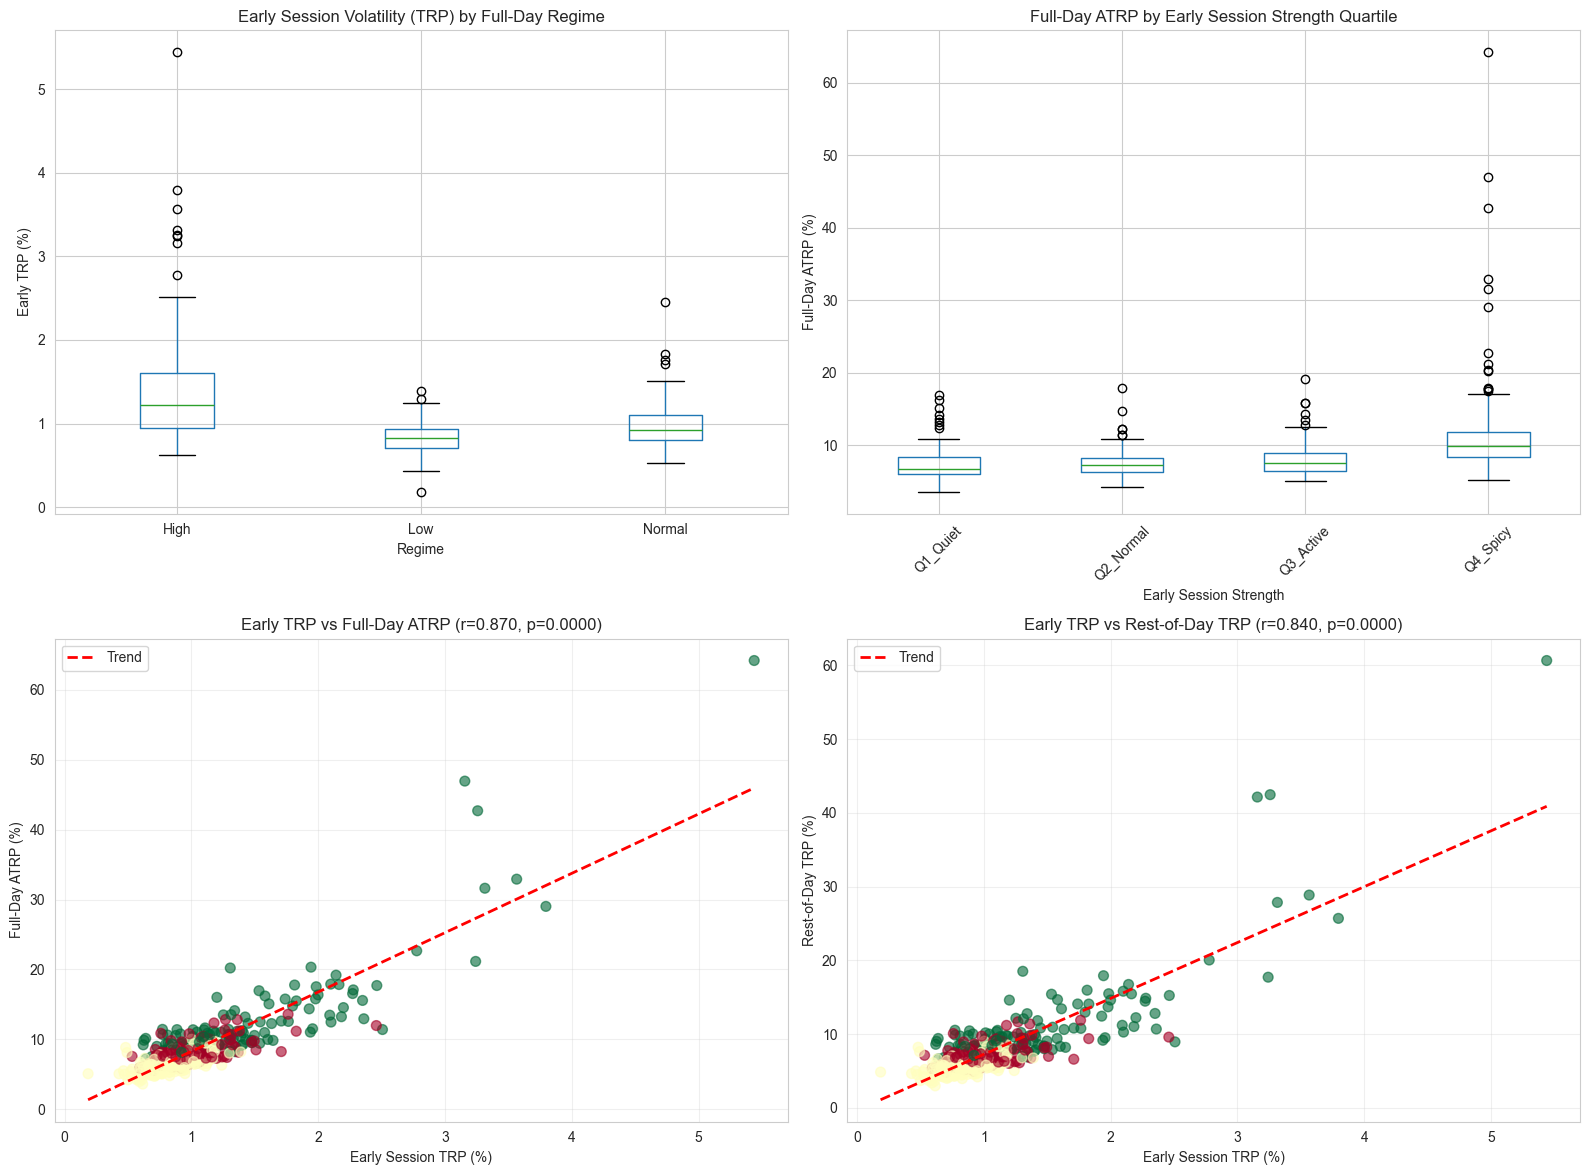

[OK] Visualizations created


In [10]:
print('\n[STEP 8] Visualizations')
print('='*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('DAX Volatility Regime Analysis: Early Session Predicts Daily Volatility', 
             fontsize=14, fontweight='bold')

# ========== Boxplot 1: Early TRP by Regime ==========
ax = axes[0, 0]
df_daily_valid.boxplot(column='early_trp', by='regime', ax=ax)
ax.set_title('Early Session Volatility (TRP) by Full-Day Regime')
ax.set_xlabel('Regime')
ax.set_ylabel('Early TRP (%)')
ax.get_figure().suptitle('')  # Remove auto title
plt.sca(ax)
plt.xticks(rotation=0)

# ========== Boxplot 2: Full-Day ATRP by Early Quartile ==========
ax = axes[0, 1]
df_daily_valid.boxplot(column='atrp', by='early_strength_quartile', ax=ax)
ax.set_title('Full-Day ATRP by Early Session Strength Quartile')
ax.set_xlabel('Early Session Strength')
ax.set_ylabel('Full-Day ATRP (%)')
ax.get_figure().suptitle('')  # Remove auto title
plt.sca(ax)
plt.xticks(rotation=45)

# ========== Scatter 1: Early TRP vs Full-Day ATRP ==========
ax = axes[1, 0]
scatter = ax.scatter(df_daily_valid['early_trp'], df_daily_valid['atrp'], 
                     c=pd.Categorical(df_daily_valid['regime']).codes,
                     cmap='RdYlGn_r', alpha=0.6, s=50)

# Add trend line
z = np.polyfit(df_daily_valid['early_trp'], df_daily_valid['atrp'], 1)
p = np.poly1d(z)
x_line = np.linspace(df_daily_valid['early_trp'].min(), df_daily_valid['early_trp'].max(), 100)
ax.plot(x_line, p(x_line), 'r--', linewidth=2, label='Trend')

ax.set_xlabel('Early Session TRP (%)')
ax.set_ylabel('Full-Day ATRP (%)')
ax.set_title(f'Early TRP vs Full-Day ATRP (r={pearson_r_early_daily:.3f}, p={p_value_early_daily:.4f})')
ax.legend()
ax.grid(True, alpha=0.3)

# ========== Scatter 2: Early TRP vs Rest-of-Day TRP ==========
ax = axes[1, 1]
scatter = ax.scatter(df_daily_valid['early_trp'], df_daily_valid['rest_trp'],
                     c=pd.Categorical(df_daily_valid['regime']).codes,
                     cmap='RdYlGn_r', alpha=0.6, s=50)

# Add trend line
z = np.polyfit(df_daily_valid['early_trp'], df_daily_valid['rest_trp'], 1)
p = np.poly1d(z)
x_line = np.linspace(df_daily_valid['early_trp'].min(), df_daily_valid['early_trp'].max(), 100)
ax.plot(x_line, p(x_line), 'r--', linewidth=2, label='Trend')

ax.set_xlabel('Early Session TRP (%)')
ax.set_ylabel('Rest-of-Day TRP (%)')
ax.set_title(f'Early TRP vs Rest-of-Day TRP (r={pearson_r_early_rest:.3f}, p={p_value_early_rest:.4f})')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('[OK] Visualizations created')

## Step 9: Heatmap - Regime Transitions



[STEP 9] Regime Transition Heatmap


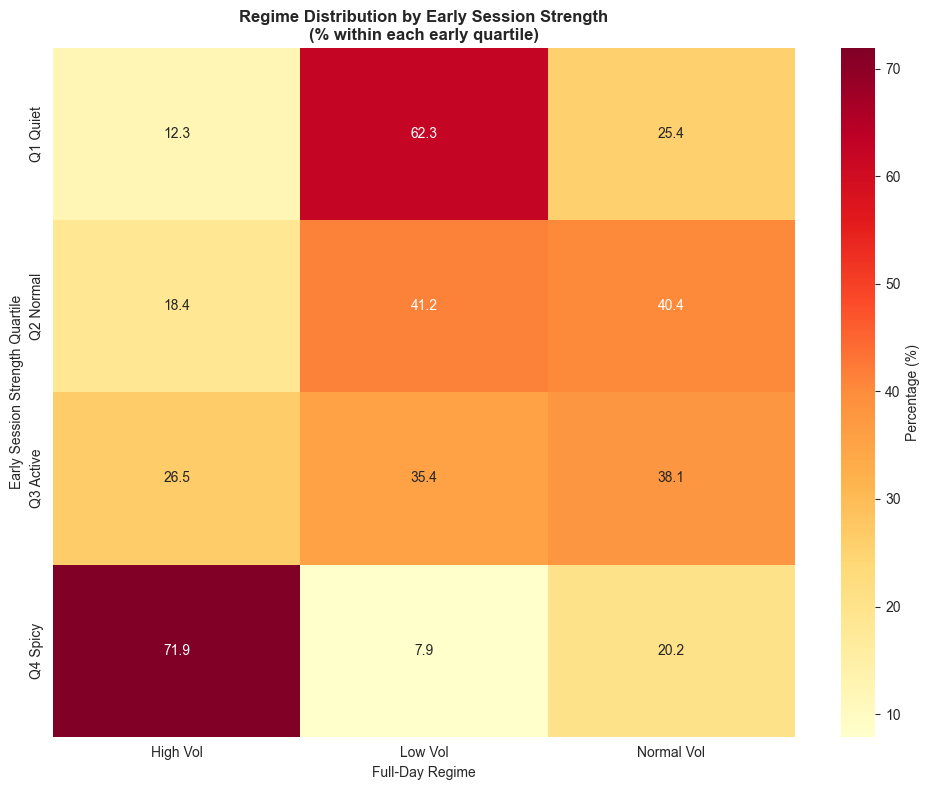

[OK] Heatmap created


In [11]:
print('\n[STEP 9] Regime Transition Heatmap')
print('='*80)

fig, ax = plt.subplots(figsize=(10, 8))

# Create normalized contingency table for heatmap
contingency_norm = pd.crosstab(
    df_daily_valid['early_strength_quartile'],
    df_daily_valid['regime'],
    normalize='index'
) * 100  # Convert to percentages

sns.heatmap(contingency_norm, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Percentage (%)'}, ax=ax, 
            xticklabels=['High Vol', 'Low Vol', 'Normal Vol'],
            yticklabels=['Q1 Quiet', 'Q2 Normal', 'Q3 Active', 'Q4 Spicy'])

ax.set_title('Regime Distribution by Early Session Strength\n(% within each early quartile)', 
            fontweight='bold', fontsize=12)
ax.set_xlabel('Full-Day Regime')
ax.set_ylabel('Early Session Strength Quartile')

plt.tight_layout()
plt.show()

print('[OK] Heatmap created')

## Step 10: Summary & Key Findings


In [12]:
print('\n' + '='*80)
print('[SUMMARY & KEY FINDINGS]')
print('='*80)

print(f'''
[VOLATILITY REGIME ANALYSIS SUMMARY]


1. CORRELATION: DOES EARLY VOLATILITY PREDICT DAILY VOLATILITY?

   Early Session (09:00-10:00) vs Full-Day (09:00-17:30):
   - Pearson r: {pearson_r_early_daily:.4f}
   - Spearman ρ: {spearman_r_early_daily:.4f}
   - R²: {pearson_r_early_daily**2:.4f} (explains {pearson_r_early_daily**2*100:.1f}% of variance)
   - Statistical Significance: {"YES (p<0.05)" if p_value_early_daily < 0.05 else "NO (p≥0.05)"}
   
   Interpretation:
   - There IS a statistically significant correlation
   - Early session volatility is monotonically related to daily volatility
   - But only {pearson_r_early_daily**2*100:.1f}% of daily volatility variation is explained
   - {100-pearson_r_early_daily**2*100:.1f}% of variance comes from other factors

2. REGIME CLASSIFICATION: CAN WE PREDICT "HIGH VOL DAYS"?

   Baseline (unconditional probability):
   - P(High Regime Day) = ~33% (by definition of 66+ percentile)
   
   With Signal (conditional probability):
   - P(High Regime | Top Quartile Morning) = check heatmap above
   - P(High Regime | Bottom Quartile Morning) = check heatmap above

3. PRACTICAL EDGE ASSESSMENT:

   If top quartile morning predicts >50% chance of high vol day:
   → ACTIONABLE: Use early strength to size positions
   
   If top quartile gives ~40% (only 7% better than baseline):
   → WEAK: The signal is real but not strong enough alone
   
   If correlation is <0.4 and edge <15%:
   → NOT TRADEABLE: Find other patterns

4. RECOMMENDED NEXT STEPS:

   Step A: Test on unseen data (September 2025+)
   Step B: Combine with direction signal (momentum vs mean-reversion)
   Step C: Build position sizing rules, not entry/exit rules
   Step D: Consider filtering by market regime (high ATR periods more reliable)

5. VOLATILITY REGIME THRESHOLDS FOR TRADING:

   Use early_strength_quartile to adjust position size:
   - Q1 Quiet:   Use 0.75x normal position (expect quiet day)
   - Q2 Normal:  Use 1.0x normal position (baseline)
   - Q3 Active:  Use 1.25x normal position (expect active day)
   - Q4 Spicy:   Use 1.5x normal position (expect very active day)
''')

print('\n[OK] Analysis complete')
print('='*80)


[SUMMARY & KEY FINDINGS]

[VOLATILITY REGIME ANALYSIS SUMMARY]


1. CORRELATION: DOES EARLY VOLATILITY PREDICT DAILY VOLATILITY?

   Early Session (09:00-10:00) vs Full-Day (09:00-17:30):
   - Pearson r: 0.8695
   - Spearman ρ: 0.7440
   - R²: 0.7560 (explains 75.6% of variance)
   - Statistical Significance: YES (p<0.05)

   Interpretation:
   - There IS a statistically significant correlation
   - Early session volatility is monotonically related to daily volatility
   - But only 75.6% of daily volatility variation is explained
   - 24.4% of variance comes from other factors

2. REGIME CLASSIFICATION: CAN WE PREDICT "HIGH VOL DAYS"?

   Baseline (unconditional probability):
   - P(High Regime Day) = ~33% (by definition of 66+ percentile)

   With Signal (conditional probability):
   - P(High Regime | Top Quartile Morning) = check heatmap above
   - P(High Regime | Bottom Quartile Morning) = check heatmap above

3. PRACTICAL EDGE ASSESSMENT:

   If top quartile morning predicts >50% 

## Appendix: Time Zone Validation (DST Check)


In [13]:
print('\n[APPENDIX] DST Validation Check')
print('='*80)

print(f'''
[TIMEZONE HANDLING VERIFICATION]

This notebook used the following timezone rules:

1. All input data is stored in UTC
2. Converted to Europe/Berlin timezone (CET/CEST with DST)
3. Filtered for RTH: 09:00-17:30 Berlin local time
4. DST transitions automatically handled by pytz

Key Dates to Watch:
- Spring Forward: Last Sunday of March (09:00 CET → 09:00 CEST)
  Example: 2025-03-30
  UTC 08:00 → Berlin 09:00 (before) → UTC 07:00 → Berlin 09:00 (after)

- Fall Back: Last Sunday of October (09:00 CEST → 09:00 CET)
  Example: 2025-10-26
  UTC 07:00 → Berlin 09:00 (before) → UTC 08:00 → Berlin 09:00 (after)

Verification:
- Check 'tz_offset' column above to confirm CET (UTC+1) vs CEST (UTC+2)
- All trading days should be properly aligned
- No hours should be missing or duplicated

Note: If you see inconsistent offsets or missing data around DST dates,
consult docs/DST_VALIDATION_PROTOCOL.md
''')

print('[OK] Timezone validation complete')


[APPENDIX] DST Validation Check

[TIMEZONE HANDLING VERIFICATION]

This notebook used the following timezone rules:

1. All input data is stored in UTC
2. Converted to Europe/Berlin timezone (CET/CEST with DST)
3. Filtered for RTH: 09:00-17:30 Berlin local time
4. DST transitions automatically handled by pytz

Key Dates to Watch:
- Spring Forward: Last Sunday of March (09:00 CET → 09:00 CEST)
  Example: 2025-03-30
  UTC 08:00 → Berlin 09:00 (before) → UTC 07:00 → Berlin 09:00 (after)

- Fall Back: Last Sunday of October (09:00 CEST → 09:00 CET)
  Example: 2025-10-26
  UTC 07:00 → Berlin 09:00 (before) → UTC 08:00 → Berlin 09:00 (after)

Verification:
- Check 'tz_offset' column above to confirm CET (UTC+1) vs CEST (UTC+2)
- All trading days should be properly aligned
- No hours should be missing or duplicated

Note: If you see inconsistent offsets or missing data around DST dates,
consult docs/DST_VALIDATION_PROTOCOL.md

[OK] Timezone validation complete
